In [1]:
%run ../code/wavelets_pca_with_zhost_1100_average_precision.py

In [2]:
%run ../code/wavelets_pca_with_zhost_1100_roc_auc.py

In [3]:
%run ../processing/read_data.py

In [254]:
import george as gg
import george.kernels as kr
import sncosmo as snc
import scipy.optimize as op
import pywt as wt

import os
import time
import numpy as np

from sklearn.decomposition import PCA

import pickle

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn import model_selection

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt



In [19]:
pd.set_option("display.max_rows", 6)

# Go direct to section Generating the labels, where we can pickle read the pickle files with the DFs processed

# ------------

## Loading GP and Wavelets function

In [264]:
def cleaning_df(df, method, clean_neg = True, percentage = 0.7):
    if clean_neg: #verifies if the value is negative and if it is under the error margin, if it is, turn to zero
        df[(df[:, 1] < 0) & (df[:, 1] > -df[:, 2]) , 1] = 0
        df = df[(df[:, 1] > 0)] #otherwise just cut off
    if method == 'std_dev': #cuts the points with error over the mean error + 1 std
        threshold = df.mean(axis = 0)[2] + df.std(axis = 0)[2]
        df_filter = df[(threshold>df[:,2])]
    elif method == 'percentage':
        threshold = df.max(axis = 0)[1] * percentage
        df_filter = df[(threshold>df[:,2])]
    elif method == '':
        df_filter = df
    return df_filter

def gaussian_process(data, filters, method, path, printar = True):
    path_to_export = path # '../../data/test/'
    x = np.linspace(data.MJD.min(), data.MJD.max(), 100)
    data_dict = {band: df[['MJD', 'FLUXCAL', 'FLUXCALERR']].values for band, df in data.groupby('FLT')}
    
    
    mus = {filters[0] : [], filters[1] : [], filters[2] : [], filters[3] : []}
    stds = {filters[0] : [], filters[1] : [], filters[2] : [], filters[3] : []}

    for band, df in data_dict.items():
        dat = cleaning_df(df, method)
        gp = gg.GP((500**2)*kr.ExpSquaredKernel(metric=20**2), fit_mean=True)
        gp.compute(dat[:,0], dat[:,2])  
        # Define the objective function (negative log-likelihood in this case).
        def nll(p):
            gp.set_parameter_vector(p)
            ll = gp.log_likelihood(dat[:,1], quiet=True)
            return -ll if np.isfinite(ll) else 1e25
    
        # And the gradient of the objective function.
        def grad_nll(p):
            gp.set_parameter_vector(p)
            return -gp.grad_log_likelihood(dat[:,1], quiet=True)
          
        p0 = gp.get_parameter_vector()
        results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")
        
        mu, var = gp.predict(dat[:,1], x, return_var=True)
        std = np.sqrt(var)
        stds[band] = std
        mus[band] = mu 
        
        if printar:
            matplotlib.use('Agg')
            plt.ioff()
            fig = plt.figure(num=None, figsize=(8, 5), dpi = 8, facecolor='w', edgecolor='w')
            plt.plot(x, mu, color= 'k', linewidth = 5)
            plt.axis('off')
            plt.savefig(path_to_export + f[24:32] + '_'+ read_sn(f)['SIM_COMMENT'][3] +'_'+ band + '.png')
            plt.close(fig)
    
    return 0, x, mus, stds

#the keys are the names of the filters in order to be the dict keys
def get_wavelets(sn, keys, method,path, wavelet = 'sym2', mlev = 2 , printar = False):
    wav = wt.Wavelet(wavelet)
    
    fmin, xstar, mu, stds = gaussian_process(sn, keys, method, path, printar = printar) 
    coeffs = [np.array(wt.swt(mu[filt], wav, level=mlev)).flatten() for filt in keys]

    return np.concatenate(coeffs)

In [202]:
path_to_read = '../../data/raw_data/'
files = []
for r, d, f in os.walk(path_to_read):
    for file in f:
        if '.DAT' in file:
            files.append(os.path.join(r, file))

### OBS: SOME FILES FOR SOME REASON COULD NOT BE PROCESSED USING WAVELETS, Those were:
### DES_SN076747, DES_SN076747. DES_SN813144
### ---------------------------
### Generating the files with treatment below

In [ ]:
#keys = ['desg' , 'desi' , 'desr' , 'desz']
#start = time.time()
#
#results_n = []
#
#for i, f in enumerate(files):
#    #results_n.append(get_wavelets(read_sn(path_to_read + f)['df'], keys, ''))
#end = time.time()
#
#print("Time running: " , (end - start)/3600) 
###Time running:  2.58798155758116

In [238]:
#keys = ['desg' , 'desi' , 'desr' , 'desz']
#
#start = time.time()
#
#results_stddev = []
#
#for i, f in enumerate(files):
#    
#    try:
#        #results_stddev.append(get_wavelets(read_sn(path_to_read + f)['df'], keys,'std_dev'))
#    except:
#        print("The file with problem was: " + str(f) + " index: " + str(i))
#
#end = time.time()
#print("Time running: " , (end - start)/3600) 
###Time running:  1.378045023083687

The file with problem was: ../../data/raw_data/DES_SN170148.DAT
The file with problem was: ../../data/raw_data/DES_SN844311.DAT
The file with problem was: ../../data/raw_data/DES_SN585441.DAT
The file with problem was: ../../data/raw_data/DES_SN089947.DAT
The file with problem was: ../../data/raw_data/DES_SN122840.DAT
The file with problem was: ../../data/raw_data/DES_SN671692.DAT
The file with problem was: ../../data/raw_data/DES_SN288256.DAT
The file with problem was: ../../data/raw_data/DES_SN769696.DAT
The file with problem was: ../../data/raw_data/DES_SN464421.DAT
The file with problem was: ../../data/raw_data/DES_SN183066.DAT
The file with problem was: ../../data/raw_data/DES_SN870945.DAT
The file with problem was: ../../data/raw_data/DES_SN148636.DAT
The file with problem was: ../../data/raw_data/DES_SN103896.DAT
The file with problem was: ../../data/raw_data/DES_SN030273.DAT
The file with problem was: ../../data/raw_data/DES_SN009140.DAT
The file with problem was: ../../data/ra

In [275]:
#keys = ['desg' , 'desi' , 'desr' , 'desz']
#
#start = time.time()
#
#results_perc = []
#
#for i, f in enumerate(files):
#    
#    #file_name = f[20:] #edit here everytime we change the folder
#    #read = read_sn(path_to_read + file_name)
#    #df = read['df']
#    
#    try:
#        #results_n.append(get_wavelets(read_sn(path_to_read + f)['df'], keys, ''))
#        #results_stddev.append(get_wavelets(read_sn(path_to_read + f)['df'], keys,'std_dev'))
#        results_perc.append(get_wavelets(read_sn(path_to_read + f)['df'], keys, 'percentage', '../../data/dl_marcelo_perc/'))
#    except:
#        print("The file with problem was: " + str(f) + " index: " + str(i))
#
#end = time.time()
#print("Time running: " , (end - start)/3600) 
###Time running:  2.58798155758116

The file with problem was: ../../data/raw_data/DES_SN210261.DAT index: 227
The file with problem was: ../../data/raw_data/DES_SN170148.DAT index: 582
The file with problem was: ../../data/raw_data/DES_SN367622.DAT index: 750
The file with problem was: ../../data/raw_data/DES_SN415102.DAT index: 825
The file with problem was: ../../data/raw_data/DES_SN792792.DAT index: 1100
The file with problem was: ../../data/raw_data/DES_SN398701.DAT index: 1575
The file with problem was: ../../data/raw_data/DES_SN844311.DAT index: 1625
The file with problem was: ../../data/raw_data/DES_SN486038.DAT index: 1654
The file with problem was: ../../data/raw_data/DES_SN585441.DAT index: 1711
The file with problem was: ../../data/raw_data/DES_SN128031.DAT index: 2100
The file with problem was: ../../data/raw_data/DES_SN282046.DAT index: 2158
The file with problem was: ../../data/raw_data/DES_SN367735.DAT index: 2485
The file with problem was: ../../data/raw_data/DES_SN089947.DAT index: 2555
The file with pr

/home/felipematheus/anaconda3/lib/python3.7/site-packages/george/gp.py:410: RuntimeWarning: invalid value encountered in subtract
  A = np.einsum("i,j", alpha, alpha) - K_inv


The file with problem was: ../../data/raw_data/DES_SN169212.DAT index: 20379
The file with problem was: ../../data/raw_data/DES_SN588165.DAT index: 20508
The file with problem was: ../../data/raw_data/DES_SN498066.DAT index: 21006
The file with problem was: ../../data/raw_data/DES_SN559445.DAT index: 21052
The file with problem was: ../../data/raw_data/DES_SN492802.DAT index: 21170
The file with problem was: ../../data/raw_data/DES_SN118863.DAT index: 21265
Time running:  3.5195248397191365


In [276]:
#keys = ['desg' , 'desi' , 'desr' , 'desz']
#
#start = time.time()
#
#for i, f in enumerate(files):
#    
#    #file_name = f[20:] #edit here everytime we change the folder
#    #read = read_sn(path_to_read + file_name)
#    #df = read['df']
#    
#    try:
#        #results_n.append(get_wavelets(read_sn(path_to_read + f)['df'], keys, ''))
#        #results_stddev.append(get_wavelets(read_sn(path_to_read + f)['df'], keys,'std_dev'))
#        gaussian_process(read_sn(path_to_read + f)['df'], keys, '', '../../data/dl_marcelo_no_treat/')
#    except:
#        print("The file with problem was: " + str(f) + " index: " + str(i))
#
#end = time.time()
#print("Time running: " , (end - start)/3600) 
###Time running:  2.58798155758116

Time running:  3.4882003411981795


In [277]:
#keys = ['desg' , 'desi' , 'desr' , 'desz']
#
#start = time.time()
#
#for i, f in enumerate(files):
#    
#    #file_name = f[20:] #edit here everytime we change the folder
#    #read = read_sn(path_to_read + file_name)
#    #df = read['df']
#    
#    try:
#        #results_n.append(get_wavelets(read_sn(path_to_read + f)['df'], keys, ''))
#        #results_stddev.append(get_wavelets(read_sn(path_to_read + f)['df'], keys,'std_dev'))
#        gaussian_process(read_sn(path_to_read + f)['df'], keys, 'std_dev', '../../data/dl_marcelo_stddev/')
#    except:
#        print("The file with problem was: " + str(f) + " index: " + str(i))
#
#end = time.time()
#print("Time running: " , (end - start)/3600) 
###Time running:  2.58798155758116

The file with problem was: ../../data/raw_data/DES_SN170148.DAT index: 582
The file with problem was: ../../data/raw_data/DES_SN844311.DAT index: 1625
The file with problem was: ../../data/raw_data/DES_SN585441.DAT index: 1711
The file with problem was: ../../data/raw_data/DES_SN089947.DAT index: 2555
The file with problem was: ../../data/raw_data/DES_SN122840.DAT index: 3050
The file with problem was: ../../data/raw_data/DES_SN671692.DAT index: 4676
The file with problem was: ../../data/raw_data/DES_SN288256.DAT index: 4987
The file with problem was: ../../data/raw_data/DES_SN769696.DAT index: 6064
The file with problem was: ../../data/raw_data/DES_SN464421.DAT index: 7506
The file with problem was: ../../data/raw_data/DES_SN183066.DAT index: 8897
The file with problem was: ../../data/raw_data/DES_SN870945.DAT index: 9822
The file with problem was: ../../data/raw_data/DES_SN148636.DAT index: 10965
The file with problem was: ../../data/raw_data/DES_SN103896.DAT index: 11145
The file wi

In [289]:
#print("Number of files with std_dev: ", len(results_stddev),". Number of files without treatment: ", len(results_n), "Number of files with percentage: ", len(results_perc))

Number of files with std_dev:  21290 . Number of files without treatment:  21316 Number of files with percentage:  21232


In [285]:
#pickle_out = open("../../models/wavelet_df_pipeline_Marcelo_SemTratamento.pickle","wb")
#pickle.dump(results_n, pickle_out)
#pickle_out.close()

In [286]:
#pickle_out = open("../../models/wavelet_df_pipeline_Marcelo_TratamentoStddev.pickle","wb")
#pickle.dump(results_stddev, pickle_out)
#pickle_out.close()

In [287]:
#pickle_out = open("../../models/wavelet_df_pipeline_Marcelo_TratamentoPerc.pickle","wb")
#pickle.dump(results_perc, pickle_out)
#pickle_out.close()

## Generating the labels:

In [290]:
not_in_stddev = [582,1625,1711,2555,3050,4676,4987,6064,7506,8897,9822,10965,11145,12290,12411,13205,13445,14301,14333,14608,14846,15059,16000,16178,17687,19156]
not_in_perc = [227,582,750,825,1100,1575,1625,1654,1711,2100,2158,2485,2555,2701,3644,3740,4079,4959,5205,5684,5904,5919,5961,6007,6424,6449,6641,6647,6749,6944,7313,8123,8849,8851,9012,9053,9475,9822,9823,9878,9986,10626,10831,11068,11219,11483,11493,11587,12723,13131,13445,13485,13664,13906,14169,14301,14315,14333,14846,15421,16352,16995,16999,17252,17371,17590,17650,17687,17959,17982,17999,18468,18537,18890,19100,19219,19297,20002,20379,20508,21006,21052,21170,21265]

In [297]:
#files_stddev = []
#files_perc = []
#for i, f in enumerate(files):
#    if i not in not_in_stddev:
#        files_stddev.append(f)
#    if i not in not_in_perc:
#        files_perc.append(f)

In [305]:
#(len(files_stddev) == len(results_stddev) and len(files_perc) == len(results_perc))

True

In [314]:
## Non optimize way of doing this
#
#labels_notreat = []
#labels_stddev = []
#labels_perc = []
#for f in files:
#    read = read_sn(f)
#    label = read['SIM_COMMENT'][3]
#    labels_notreat.append(label)
#    
#for f in files_stddev:
#    read = read_sn(f)
#    label = read['SIM_COMMENT'][3]
#    labels_stddev.append(label)
#    
#for f in files_perc:
#    read = read_sn(f)
#    label = read['SIM_COMMENT'][3]
#    labels_perc.append(label)

In [324]:
#(len(files_stddev) == len(labels_stddev) and len(files_perc) == len(labels_perc)) and len(files) == len(labels_notreat)

True

In [319]:
pickle_out = open("../../models/label_SemTratamento.pickle","wb")
pickle.dump(labels_notreat, pickle_out)
pickle_out.close()

In [320]:
#pickle_out = open("../../models/labels_Stddev.pickle","wb")
#pickle.dump(labels_stddev, pickle_out)
#pickle_out.close()

In [321]:
#pickle_out = open("../../models/labels_Perc.pickle","wb")
#pickle.dump(labels_perc, pickle_out)
#pickle_out.close()

In [325]:
pickle_results = open("../../models/wavelet_df_pipeline_Marcelo_SemTratamento.pickle","rb")
pickle_labels = open("../../models/label_SemTratamento.pickle","rb")

r1 = pickle.load(pickle_results)
l1 = pickle.load(pickle_labels)

In [336]:
#l1==labels_notreat

True

In [335]:
#all(r1[0]==results_n[0])

True

In [337]:
pickle_results = open("../../models/wavelet_df_pipeline_Marcelo_TratamentoStddev.pickle","rb")
pickle_labels = open("../../models/labels_Stddev.pickle","rb")

r2 = pickle.load(pickle_results)
l2 = pickle.load(pickle_labels)

In [341]:
#l2==labels_stddev

True

In [342]:
#all(r2[-1]==results_stddev[-1])

True

In [340]:
pickle_results = open("../../models/wavelet_df_pipeline_Marcelo_TratamentoPerc.pickle","rb")
pickle_labels = open("../../models/labels_Perc.pickle","rb")

r3 = pickle.load(pickle_results)
l3 = pickle.load(pickle_labels)

In [345]:
#l3==labels_perc

True

In [346]:
#all(r3[-1]==results_perc[-1])

True

## Wavelets done, PCA now

In [373]:
pca = PCA(n_components=20)
pca.fit(r1)  
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[7.75139627e-01 1.11045532e-01 5.09795625e-02 1.92517498e-02
 1.03859442e-02 7.71441752e-03 5.63014020e-03 4.70266276e-03
 3.34344041e-03 2.22753309e-03 1.57727944e-03 1.49117888e-03
 1.02304307e-03 9.17428064e-04 7.46378592e-04 6.19093209e-04
 5.12147206e-04 4.40270591e-04 3.24403584e-04 2.78871684e-04]
[600322.42813674 227219.26123098 153954.59346039  94608.40123326
  69489.24486854  59888.87696224  51162.78822015  46759.14024077
  39426.78753939  32181.52948381  27080.01625222  26330.52210398
  21809.29159654  20652.87943878  18628.34129931  16965.73266035
  15430.92651381  14307.19305601  12281.10432938  11386.67194185]


In [374]:
df1_pca_20 = pca.fit_transform(r1) #or pca.transform(results), same thing

In [376]:
pca = PCA(n_components=20)
pca.fit(r2)  
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[8.08647467e-01 8.33815865e-02 4.23725731e-02 1.48731534e-02
 1.31549595e-02 7.08009948e-03 6.20994046e-03 3.83201416e-03
 3.31470645e-03 3.24112794e-03 2.02171447e-03 1.86506921e-03
 1.40284138e-03 1.22209573e-03 1.14586046e-03 1.04790392e-03
 9.23452923e-04 6.65578983e-04 5.87773763e-04 4.33689740e-04]
[567138.87606156 182114.64850976 129823.17366333  76915.05085843
  72336.01170912  53067.60436113  49699.67183202  39041.21774946
  36310.50920221  35905.24462807  28357.6156732   27236.87506213
  23621.85972207  22047.65558423  21348.90822884  20415.99426286
  19165.36889209  16270.82607556  15290.26107062  13134.07151617]


In [377]:
df2_pca_20 = pca.fit_transform(r2) 

In [379]:
pca = PCA(n_components=20)
pca.fit(r3)  
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[7.75148767e-01 1.11049268e-01 5.09766783e-02 1.92527644e-02
 1.03859251e-02 7.71314018e-03 5.62587600e-03 4.70173361e-03
 3.34355917e-03 2.22695433e-03 1.57689450e-03 1.49095287e-03
 1.02323219e-03 9.16631755e-04 7.45814736e-04 6.18985501e-04
 5.11693779e-04 4.39811168e-04 3.24049243e-04 2.78669692e-04]
[600308.69083556 227216.54423588 153945.80788357  94608.17132523
  69487.18100766  59882.19519343  51141.93761248  46753.17510607
  39426.35308218  32176.42248985  27075.93232785  26327.76900263
  21810.6795838   20643.32023806  18620.76763064  16963.76855124
  15423.65025805  14299.31478422  12274.04202325  11382.2198419 ]


In [380]:
df3_pca_20 = pca.fit_transform(r3) 

## Using Pipelines

In [365]:
conversion = {'IIL' : 5, 'IIP' : 7, 'II' : 4, 'IIn' : 6, 'Ia' : 0, 'Ib' : 1, 'Ibc' : 2, 'Ic' : 3}
conversion_bool = {'IIL' : 0, 'IIP' : 0, 'II' : 0, 'IIn' : 0, 'Ia' : 1, 'Ib' : 0, 'Ibc' : 0, 'Ic' : 0}

lbool1 = []
l1_classes = []
for l in l1:
    lbool1.append(conversion_bool[l])
    lclass1.append(conversion[l])

lbool2 = []
l2_classes = []
for l in l2:
    lbool2.append(conversion_bool[l])
    lclass2.append(conversion[l])

lbool3 = []
l3_classes = []
for l in l3:
    lbool3.append(conversion_bool[l])
    lclass3.append(conversion[l])

# K-FOLD, Train and Evaluation

In [384]:
X = df1_pca_20
y = np.array(lbool1)
kf = KFold(n_splits=5)
X_train = []
X_test = []
y_train = []
y_test = []
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train.append(X[train_index])
    X_test.append(X[test_index])
    y_train.append(y[train_index])
    y_test.append(y[test_index])
    
Xc = df1_pca_20
yc = np.array(lclass1)
kfc = KFold(n_splits=5)
Xc_train = []
Xc_test = []
yc_train = []
yc_test = []
for train_index, test_index in kfc.split(Xc):
    print("TRAIN:", train_index, "TEST:", test_index)
    Xc_train.append(Xc[train_index])
    Xc_test.append(Xc[test_index])
    yc_train.append(yc[train_index])
    yc_test.append(yc[test_index])

TRAIN: [ 4264  4265  4266 ... 21313 21314 21315] TEST: [   0    1    2 ... 4261 4262 4263]
TRAIN: [    0     1     2 ... 21313 21314 21315] TEST: [4264 4265 4266 ... 8524 8525 8526]
TRAIN: [    0     1     2 ... 21313 21314 21315] TEST: [ 8527  8528  8529 ... 12787 12788 12789]
TRAIN: [    0     1     2 ... 21313 21314 21315] TEST: [12790 12791 12792 ... 17050 17051 17052]
TRAIN: [    0     1     2 ... 17050 17051 17052] TEST: [17053 17054 17055 ... 21313 21314 21315]


In [405]:
X_std = df2_pca_20
y_std = np.array(lbool2)
kf_std = KFold(n_splits=5)
X_train_std = []
X_test_std = []
y_train_std = []
y_test_std = []
for train_index, test_index in kf_std.split(X_std):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_std.append(X_std[train_index])
    X_test_std.append(X_std[test_index])
    y_train_std.append(y_std[train_index])
    y_test_std.append(y_std[test_index])

Xc_std = df2_pca_20
yc_std = np.array(lclass2)
kfc_std = KFold(n_splits=5)
Xc_train_std = []
Xc_test_std = []
yc_train_std = []
yc_test_std = []
for train_index, test_index in kfc_std.split(Xc_std):
    print("TRAIN:", train_index, "TEST:", test_index)
    Xc_train_std.append(Xc_std[train_index])
    Xc_test_std.append(Xc_std[test_index])
    yc_train_std.append(yc_std[train_index])
    yc_test_std.append(yc_std[test_index])

TRAIN: [ 4258  4259  4260 ... 21287 21288 21289] TEST: [   0    1    2 ... 4255 4256 4257]
TRAIN: [    0     1     2 ... 21287 21288 21289] TEST: [4258 4259 4260 ... 8513 8514 8515]
TRAIN: [    0     1     2 ... 21287 21288 21289] TEST: [ 8516  8517  8518 ... 12771 12772 12773]
TRAIN: [    0     1     2 ... 21287 21288 21289] TEST: [12774 12775 12776 ... 17029 17030 17031]
TRAIN: [    0     1     2 ... 17029 17030 17031] TEST: [17032 17033 17034 ... 21287 21288 21289]


In [406]:
X_perc = df3_pca_20
y_perc = np.array(lbool3)
kf_perc = KFold(n_splits=5)
X_train_perc = []
X_test_perc = []
y_train_perc = []
y_test_perc = []
for train_index, test_index in kf_perc.split(X_perc):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_perc.append(X_perc[train_index])
    X_test_perc.append(X_perc[test_index])
    y_train_perc.append(y_perc[train_index])
    y_test_perc.append(y_perc[test_index])
    
Xc_perc = df3_pca_20
yc_perc = np.array(lclass3)
kfc_perc = KFold(n_splits=5)
Xc_train_perc = []
Xc_test_perc = []
yc_train_perc = []
yc_test_perc = []
for train_index, test_index in kfc_perc.split(Xc_perc):
    print("TRAIN:", train_index, "TEST:", test_index)
    Xc_train_perc.append(Xc_perc[train_index])
    Xc_test_perc.append(Xc_perc[test_index])
    yc_train_perc.append(yc_perc[train_index])
    yc_test_perc.append(yc_perc[test_index])

TRAIN: [ 4247  4248  4249 ... 21229 21230 21231] TEST: [   0    1    2 ... 4244 4245 4246]
TRAIN: [    0     1     2 ... 21229 21230 21231] TEST: [4247 4248 4249 ... 8491 8492 8493]
TRAIN: [    0     1     2 ... 21229 21230 21231] TEST: [ 8494  8495  8496 ... 12737 12738 12739]
TRAIN: [    0     1     2 ... 21229 21230 21231] TEST: [12740 12741 12742 ... 16983 16984 16985]
TRAIN: [    0     1     2 ... 16983 16984 16985] TEST: [16986 16987 16988 ... 21229 21230 21231]


In [452]:
np.random.seed(9)
scores = model_selection.cross_val_score(exported_pipeline, df1_pca_20, lbool1, cv=5)

In [453]:
np.random.seed(9)
scores_std = model_selection.cross_val_score(exported_pipeline, df2_pca_20, lbool2, cv=5)

In [454]:
np.random.seed(9)
scores_perc = model_selection.cross_val_score(exported_pipeline, df3_pca_20, lbool3, cv=5)

In [455]:
print("Without any pre treatment: ", scores,'\n',"With standard deviation pre treatment: ", scores_std,'\n',"Without percentage pre treatment: ", scores_perc)

Without any pre treatment:  [0.93269231 0.93198874 0.93478771 0.92892329 0.93852651] 
 With standard deviation pre treatment:  [0.92791735 0.93073491 0.92790042 0.92459479 0.93093728] 
 Without percentage pre treatment:  [0.93265835 0.93430657 0.93454203 0.92863872 0.93969376]


In [ ]:
np.random.seed(9)
scoresc = model_selection.cross_val_score(exported_pipeline, df1_pca_20, lclass1, cv=5)

In [ ]:
np.random.seed(9)
scoresc_std = model_selection.cross_val_score(exported_pipeline, df2_pca_20, lclass2, cv=5)

In [ ]:
np.random.seed(9)
scoresc_perc = model_selection.cross_val_score(exported_pipeline, df3_pca_20, lclass3, cv=5)

In [ ]:
print("Without any pre treatment: ", scoresc,'\n',"With standard deviation pre treatment: ", scoresc_std,'\n',"Without percentage pre treatment: ", scoresc_perc)

# Fitting the best models

In [451]:
exported_pipeline.fit(X_train[0], y_train[0])

In [402]:
y_pred = exported_pipeline.predict(X_test[0])
cm = confusion_matrix(y_test[0], y_pred)

In [403]:
cm

array([[3097,  169],
       [ 122,  876]])

In [407]:
exported_pipeline.fit(X_train_perc[0], y_train_perc[0])

Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=None,
       transformer_list=[('stackingestimator-1', StackingEstimator(estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=21, p=1,
           weights='uniform'))), ('....8500000000000001, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False))])

In [408]:
np.random.seed(9)
y_pred_perc = exported_pipeline.predict(X_test_perc[0])
cm_perc = confusion_matrix(y_test_perc[0], y_pred_perc)

In [409]:
cm_perc

array([[3088,  169],
       [ 116,  874]])

In [456]:
np.random.seed(9)
exported_pipeline.fit(X_train_perc[4], y_train_perc[4])

Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=None,
       transformer_list=[('stackingestimator-1', StackingEstimator(estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=21, p=1,
           weights='uniform'))), ('....8500000000000001, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False))])

In [457]:
np.random.seed(9)
y_pred_perc = exported_pipeline.predict(X_test_perc[4])
cm_perc = confusion_matrix(y_test_perc[4], y_pred_perc)
print(cm_perc)

[[3068  143]
 [ 116  919]]


In [458]:
exported_pipeline.score(X_test_perc[4],y=y_test_perc[4])

0.9390014130946773

In [469]:
np.random.seed(9)
exported_pipeline.fit(X_train[4], y_train[4])

Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=None,
       transformer_list=[('stackingestimator-1', StackingEstimator(estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=21, p=1,
           weights='uniform'))), ('....8500000000000001, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False))])

In [470]:
y_pred = exported_pipeline.predict(X_test[4])
cm = confusion_matrix(y_test[4], y_pred)
print(cm)

[[3066  157]
 [ 115  925]]


In [471]:
exported_pipeline.score(X_test[4],y=y_test[4])

0.9361951677222613

# Confusion Matrices

In [462]:
%matplotlib inline

import matplotlib.pyplot as plt

Confusion matrix, without normalization
[[3068  143]
 [ 116  919]]
Normalized confusion matrix
[[0.95546559 0.04453441]
 [0.11207729 0.88792271]]


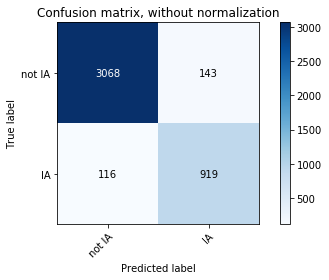

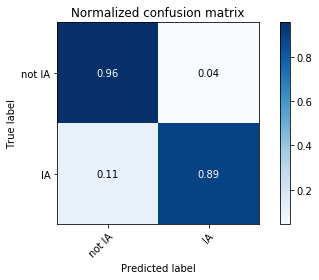

In [468]:
plot_confusion_matrix(y_test_perc[4],y_pred_perc, ['not IA','IA' ], normalize=False)
plot_confusion_matrix(y_test_perc[4],y_pred_perc, ['not IA','IA' ], normalize=True)

Confusion matrix, without normalization
[[3066  157]
 [ 115  925]]
Normalized confusion matrix
[[0.95128762 0.04871238]
 [0.11057692 0.88942308]]


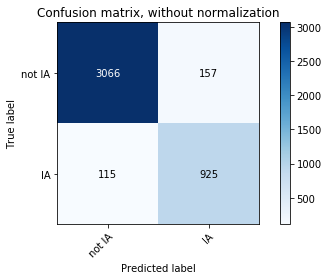

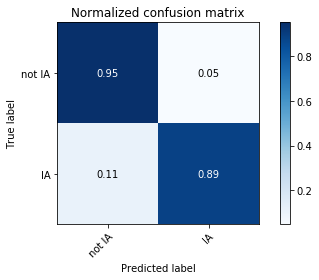

In [472]:
plot_confusion_matrix(y_test[4],y_pred, ['not IA','IA' ], normalize=False)
plot_confusion_matrix(y_test[4],y_pred, ['not IA','IA' ], normalize=True)

In [ ]:
#def plot_confusion_matrix(y_true, y_pred, classes,
#                          normalize=False,
#                          title=None,
#                          cmap=plt.cm.Blues):
#    """
#    This function prints and plots the confusion matrix.
#    Normalization can be applied by setting `normalize=True`.
#    """
#    if not title:
#        if normalize:
#            title = 'Normalized confusion matrix'
#        else:
#            title = 'Confusion matrix, without normalization'
#
#    # Compute confusion matrix
#    cm = confusion_matrix(y_true, y_pred)
#    # Only use the labels that appear in the data
#    #classes = classes[unique_labels(y_true, y_pred)]
#    if normalize:
#        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#        print("Normalized confusion matrix")
#    else:
#        print('Confusion matrix, without normalization')
#
#    print(cm)
#
#    fig, ax = plt.subplots()
#    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
#    ax.figure.colorbar(im, ax=ax)
#    # We want to show all ticks...
#    ax.set(xticks=np.arange(cm.shape[1]),
#           yticks=np.arange(cm.shape[0]),
#           # ... and label them with the respective list entries
#           xticklabels=classes, yticklabels=classes,
#           title=title,
#           ylabel='True label',
#           xlabel='Predicted label')
#
#    # Rotate the tick labels and set their alignment.
#    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#             rotation_mode="anchor")
#
#    # Loop over data dimensions and create text annotations.
#    fmt = '.2f' if normalize else 'd'
#    thresh = cm.max() / 2.
#    for i in range(cm.shape[0]):
#        for j in range(cm.shape[1]):
#            ax.text(j, i, format(cm[i, j], fmt),
#                    ha="center", va="center",
#                    color="white" if cm[i, j] > thresh else "black")
#    fig.tight_layout()
#    return ax

In [ ]:
#import matplotlib
#matplotlib.use('WebAgg')
#import matplotlib.pyplot as plt
#def plot_confusion_matrix(y_true, y_pred, classes,
#                          normalize=False,
#                          title=None,
#                          cmap=plt.cm.Blues):
#    """
#    This function prints and plots the confusion matrix.
#    Normalization can be applied by setting `normalize=True`.
#    """
#    if not title:
#        if normalize:
#            title = 'Normalized confusion matrix'
#        else:
#            title = 'Confusion matrix, without normalization'
#
#    # Compute confusion matrix
#    cm = confusion_matrix(y_true, y_pred)
#    # Only use the labels that appear in the data
#    #classes = classes[unique_labels(y_true, y_pred)]
#    if normalize:
#        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#        print("Normalized confusion matrix")
#    else:
#        print('Confusion matrix, without normalization')
#
#    print(cm)
#
#    fig, ax = plt.subplots()
#    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
#    ax.figure.colorbar(im, ax=ax)
#    # We want to show all ticks...
#    ax.set(xticks=np.arange(cm.shape[1]),
#           yticks=np.arange(cm.shape[0]),
#           # ... and label them with the respective list entries
#           xticklabels=classes, yticklabels=classes,
#           title=title,
#           ylabel='True label',
#           xlabel='Predicted label')
#
#    # Rotate the tick labels and set their alignment.
#    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#             rotation_mode="anchor")
#
#    # Loop over data dimensions and create text annotations.
#    fmt = '.2f' if normalize else 'd'
#    thresh = cm.max() / 2.
#    for i in range(cm.shape[0]):
#        for j in range(cm.shape[1]):
#            ax.text(j, i, format(cm[i, j], fmt),
#                    ha="center", va="center",
#                    color="white" if cm[i, j] > thresh else "black")
#    fig.tight_layout()
#    return ax

In [ ]:
##DRAFT VERSION USED TO 'SN_examples.ipyb'
#def get_wavelets(sn, wavelet = 'sym2', mlev = 2):
#    keys = ['sdssg', 'sdssi', 'sdssr', 'sdssz']
#    wav = wt.Wavelet(wavelet)
#    
#    fmin, xstar, mu, std = gaussian_process(sn)
#    for filt in keys: 
#        coeffs = [np.array(wt.swt(mu[filt], wav, level=mlev)).flatten()]
#
#    return np.concatenate(coeffs)
#
#
#def gaussian_process(data):
#    x = np.linspace(data.time.min(), data.time.max(), 100)
#    data_dict = {band: df[['time', 'flux', 'fluxerr']].values for band, df in data.groupby('band')}
#    
#    mus = {'sdssg' : [], 'sdssi' : [], 'sdssr' : [], 'sdssz' : []}
#    for band, dat in data_dict.items():
#        gp = gg.GP((500**2)*kr.ExpSquaredKernel(metric=20**2), fit_mean=True)
#        gp.compute(dat[:,0], dat[:,2])  
#        # Define the objective function (negative log-likelihood in this case).
#        def nll(p):
#            gp.set_parameter_vector(p)
#            ll = gp.log_likelihood(dat[:,1], quiet=True)
#            return -ll if np.isfinite(ll) else 1e25
#    
#        # And the gradient of the objective function.
#        def grad_nll(p):
#            gp.set_parameter_vector(p)
#            return -gp.grad_log_likelihood(dat[:,1], quiet=True)
#          
#        p0 = gp.get_parameter_vector()
#        results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")
#        
#        mu, var = gp.predict(dat[:,1], x, return_var=True)
#        std = np.sqrt(var)
#        stds[band] = std
#        mus[band] = mu 
#    
#    return 0, x, mus, stds

###Numpy approach:
##files = np.empty([0])
##for r, d, f in os.walk(path_to_read):
##    for file in f:
##        if '.DAT' in file:
##            print(file)
##            files = np.append(files, os.path.join(r, file))